In [1]:
import numpy as np

import matplotlib.pyplot as plt
import cv2  
import sys

from PIL import Image, ImageOps
from utils import plot_filtered_image, plot_multiple_rows

%matplotlib inline

In [ ]:
!unzip /content/images.zip

## 3. Image Pyramids

Normally, we used to work with an image of constant size. But on some occasions, we need to work with (the same) images in different resolution. For example, while searching for something in an image, like face, we are not sure at what size the object will be present in said image. In that case, we will need to create a set of the same image with different resolutions and search for object in all of them. These set of images with different resolutions are called Image Pyramids (because when they are kept in a stack with the highest resolution image at the bottom and the lowest resolution image at top, it looks like a pyramid).

There are two kinds of Image Pyramids. 1) **Gaussian Pyramid** and 2) **Laplacian Pyramids**

Higher level (Low resolution) in a Gaussian Pyramid is formed by removing consecutive rows and columns in Lower level (higher resolution) image. Then each pixel in higher level is formed by the contribution from 5 pixels in underlying level with gaussian weights. By doing so, a $M \times N$ image becomes $\frac{M}{2}\times\frac{M}{2}$ image. So area reduces to one-fourth of original area. It is called an Octave. The same pattern continues as we go upper in pyramid (ie, resolution decreases). Similarly while expanding, area becomes 4 times in each level. We can find Gaussian pyramids using `cv2.pyrDown()` and `cv2.pyrUp()` functions.

One application of Pyramids is **Image Blending**. For example, in image stitching, you will need to stack two images together, but it may not look good due to discontinuities between images. In that case, image blending with Pyramids gives you seamless blending without leaving much data in the images. One classical example of this is the blending of two fruits, Orange and Apple.

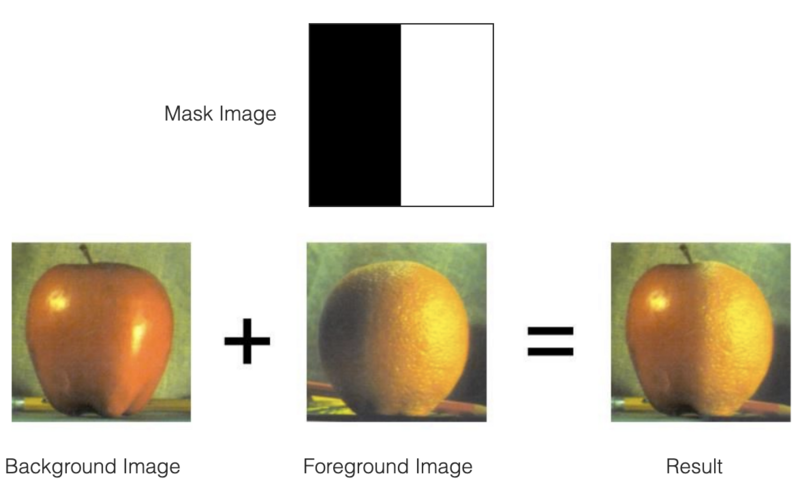

Before moving on, **we suggest you to read [this article](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f) about image blending with pyramids**. It will help you understand the basic concepts for solving this exercise.

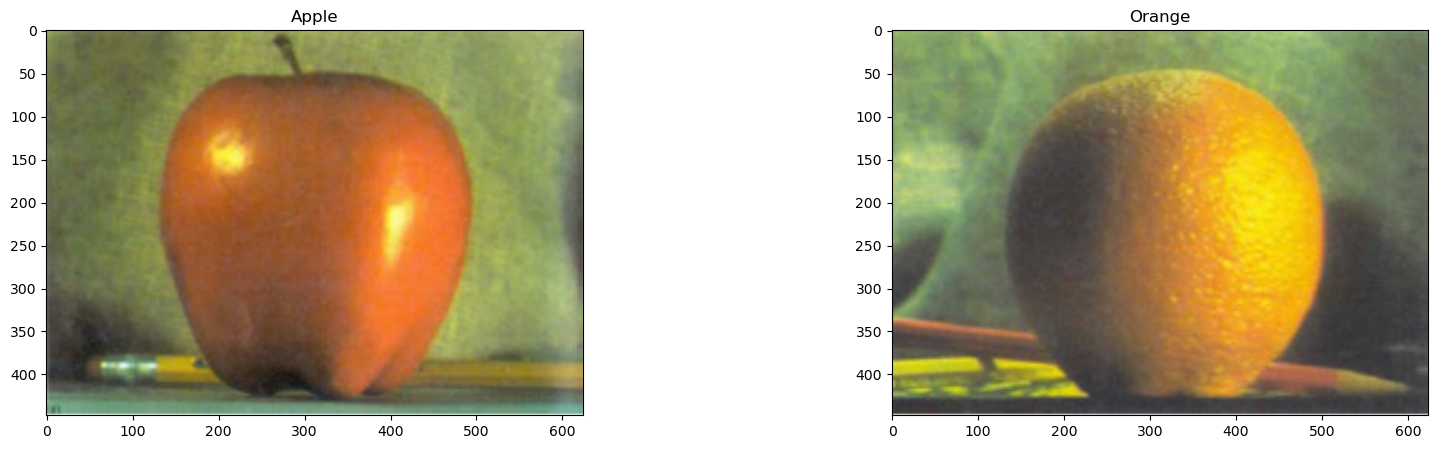

In [2]:
""" Load two images """
apple = np.array(Image.open('images/apple.png'))
orange = np.array(Image.open('images/orange.png'))

plot_filtered_image(apple, orange, "Orange", "Apple")

A naïve idea might be to take one-half of both images and glue them together. In this case, the result would not be very realistic!

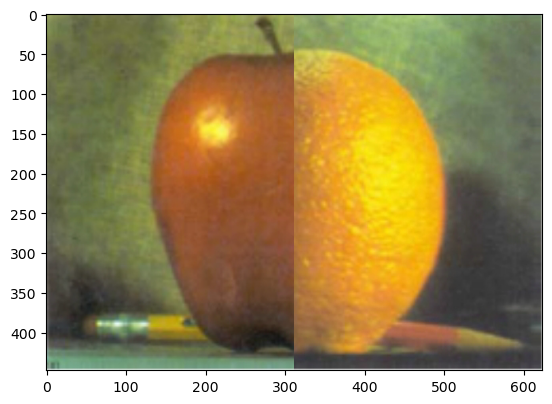

In [3]:
# Image with direct connecting each half
direct_connection = np.hstack((apple[:,:apple.shape[1]//2],orange[:,orange.shape[1]//2:]))
plt.imshow(direct_connection)

We start by computing the **Gaussian Pyramids** of the two images up to 6 levels. In this first phase, the image size decreases by a factor of 2, and the scale of the aggregate gaussian smoothing filter applied increases by a factor of 2.

In [4]:
"""Find Gaussian Pyramids for two images. Up to 6 level"""
def gaussian_pyramid(image, levels):
    G = np.copy(image)
    g_pyramid = [G]

    # Loop over all levels and apply the pyrDown function to scale down the image G
    # Append the results to the g_pyramid list
    for level in range(levels):
        G = cv2.pyrDown(G)  # use the pyrDown from OpenCV
        g_pyramid.append(G)

    return g_pyramid

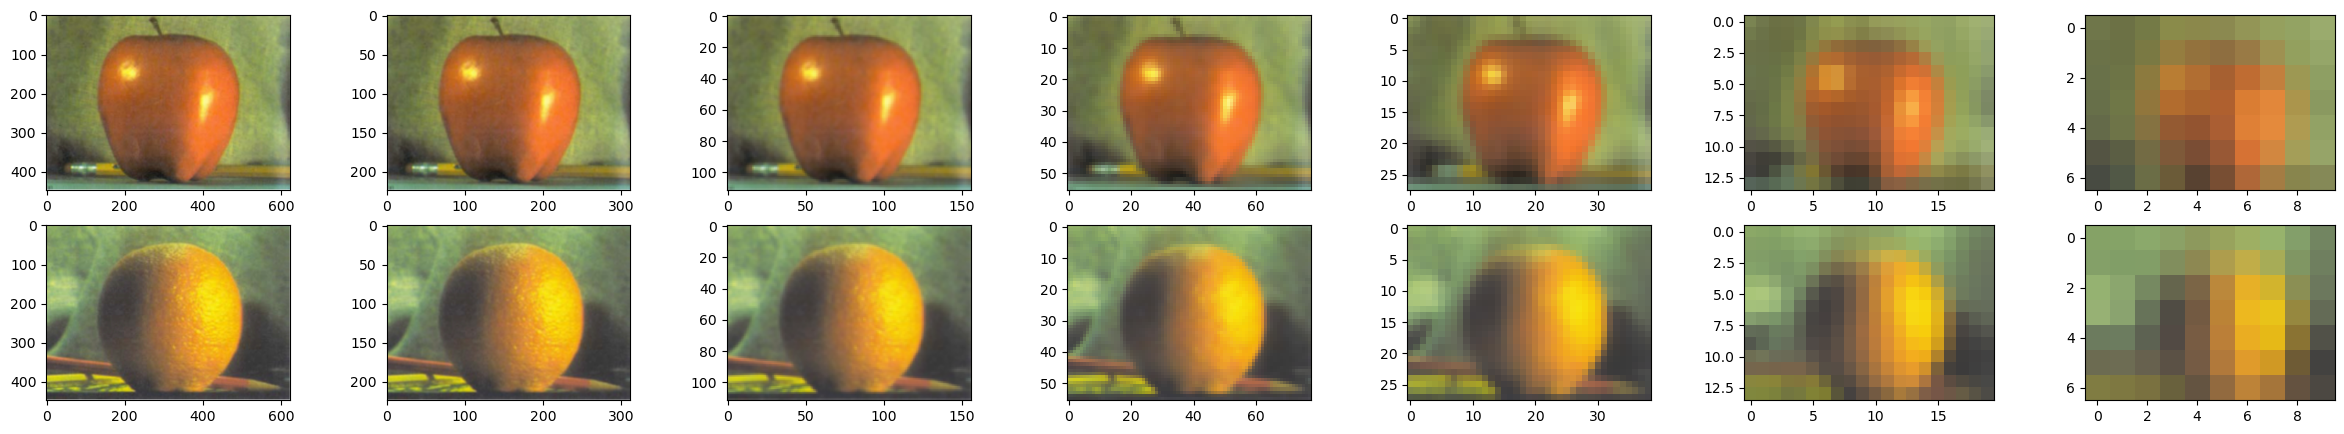

In [27]:
levels = 6

gp_apple = gaussian_pyramid(apple, levels)
gp_orange = gaussian_pyramid(orange, levels)

plot_multiple_rows({'apple':gp_apple,'orange':gp_orange}, 2, len(gp_orange), (30,5))

Similarly, we compute the Laplacian Pyramids from the Gaussian Pyramids. To construct the Laplacian at a given level i, we first upsample the downscaled image of the next smallest level from the Gaussian pyramid. We subtract the upsampled image from the image in the Gaussian pyramid at the current level.

**Note**: by default, the size of the output image produced by the `cv2.pyrUp()` function is computed as `Size(src.cols\*2, (src.rows\*2)`, but in any case. Therefore, you may need to apply a resize to match the shapes of the Gaussian Pyramids (see the `cv2.resize` function documentation).

In [28]:
def resize_image(gp_image, lp_image):
     """Resizes the lp_image .

     Args:
         gp_image (np.ndarray): an image from the Gaussian pyramid
         lp_image (np.ndarray): an image from the Laplacian pyramid

     Returns:
         np.ndarray: a resized lp_image
     """
     resized = lp_image
     
     if lp_image.shape != gp_image.shape:
        height = gp_image.shape[0]
        width = gp_image.shape[1]
        resized = cv2.resize(src=lp_image, dsize=(width,height))

     return resized

In [29]:
"""From Gaussian Pyramids, find their Laplacian Pyramids"""
def laplacian_pyramids(gp_pyramid, levels):
    lp_pyramid = [gp_pyramid[levels-1]]  # Initialize the list with the gp_pyramid at levels -1
    for i in range(levels-1, 0, -1):   # loop from levels-1 to 0

        GE = cv2.pyrUp(gp_pyramid[i]) # Use the pyrUp frunction
        
        GE = resize_image(gp_pyramid[i-1], GE) # Resize the image
        
        L = cv2.subtract(gp_pyramid[i-1],GE)  # subtract the upsampled image from the image at the current scale (i-1) in the Gaussian pyramid
        lp_pyramid.append(L)
    
    return lp_pyramid

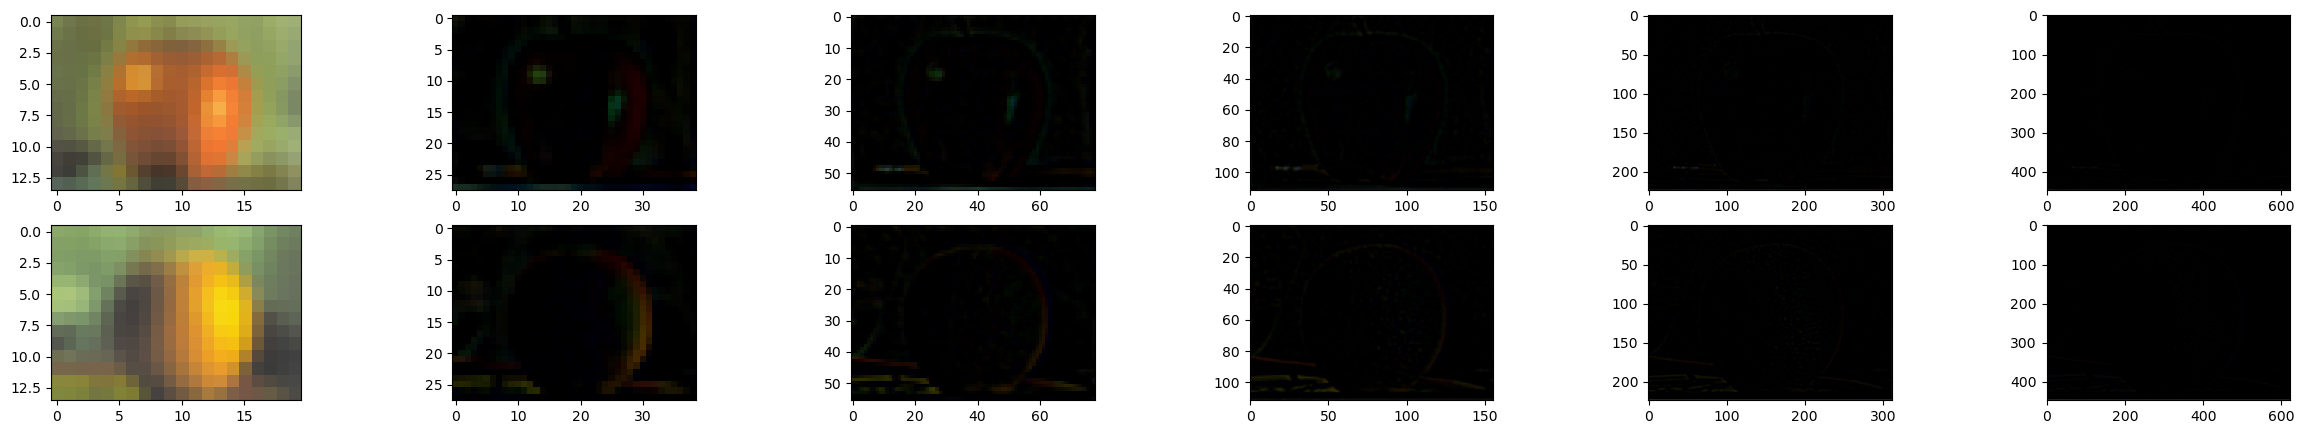

In [41]:
lp_apple = laplacian_pyramids(gp_apple, levels)
lp_orange = laplacian_pyramids(gp_orange, levels)

plot_multiple_rows({'apple':lp_apple, 'orange':lp_orange},2,len(lp_orange),(30,5))

Now we join the left half of apple and right half of orange in each levels of Laplacian Pyramids.

In [42]:
def join_pyramids(lp_A, lp_B):
    LS = []
    for la, lb in zip(lp_A,lp_B):
        rows_la, cols_la, dpt_la = la.shape
        rows_lb, cols_lb, dpt_lb = lb.shape
        ls = np.hstack((la[:, :cols_la//2, :], lb[:, cols_lb//2:, :]))
        LS.append(ls)
    
    return LS

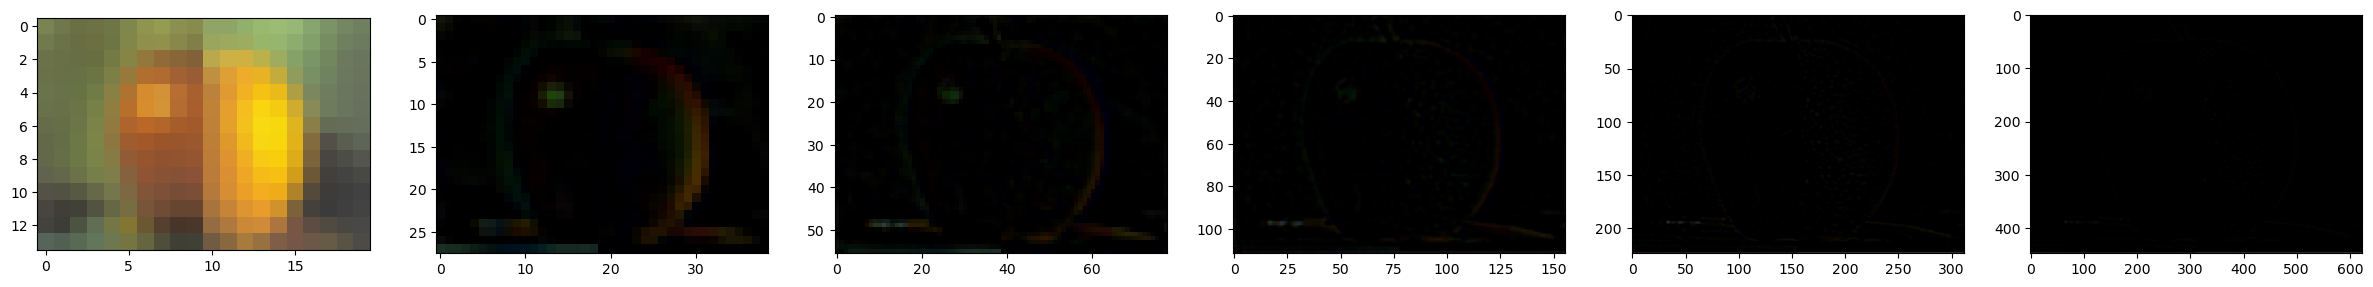

In [57]:
LS = join_pyramids(lp_apple,lp_orange)

plot_multiple_rows({'LS':LS}, 1, len(LS), (30,5))

Applying the Gaussian filter to the subsampled mask makes the image blend smooth. The mask serves to help us combine the Laplacian pyramids for the two inputs.

Finally from this joint image pyramids, reconstruct the original image.

In [79]:
'''Reconstruct'''

def reconstruct(j_pyramids, levels):
    reconstructed = j_pyramids[0]
    
    for i in range(1,levels):

        reconstructed = resize_image(j_pyramids[i], cv2.pyrUp(reconstructed)) 

        reconstructed = cv2.add(reconstructed, j_pyramids[i]) # add the combined Laplacian to the original Gaussian-resized images combined with their respective masks that you computed above
        #reconstructed = reconstructed + j_pyramids[i] -> Green dots

    return reconstructed

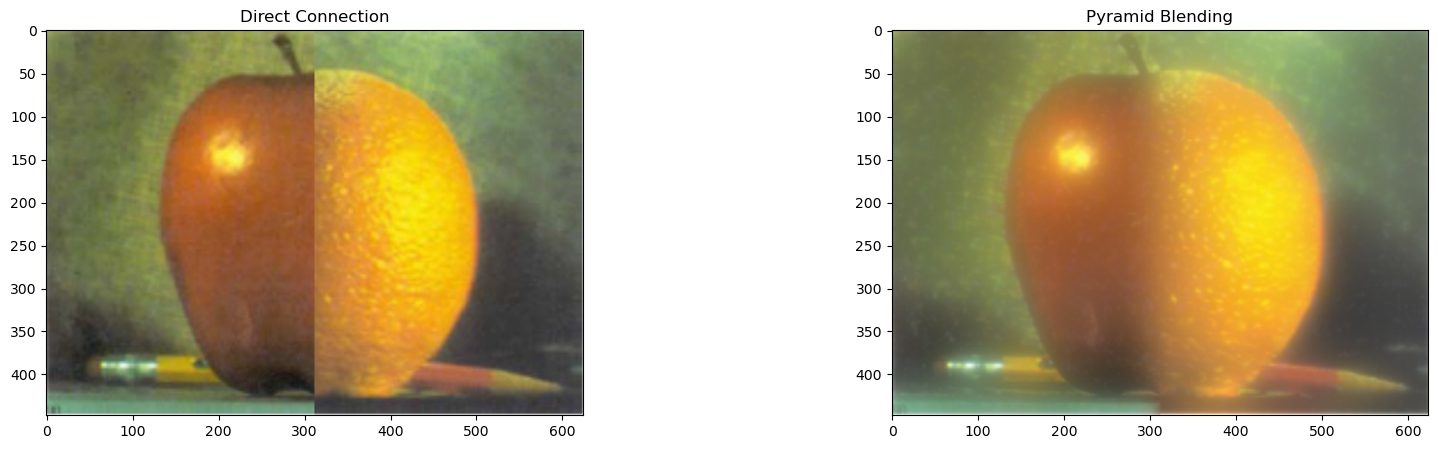

In [80]:
reconstructed = reconstruct(LS, levels)

plot_filtered_image(direct_connection, reconstructed, "Pyramid Blending", "Direct Connection")